# Stock price prediction using LSTM

## 1. Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 20, 10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

## 2. Read the dataset:

In [5]:
df = pd.read_csv("data_sets/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


## 3. Analyze the closing prices from dataframe:

C:\Users\tarza\AppData\Local\Temp\ipykernel_21436\3057597638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df.Date, format="%Y-%m-%d")


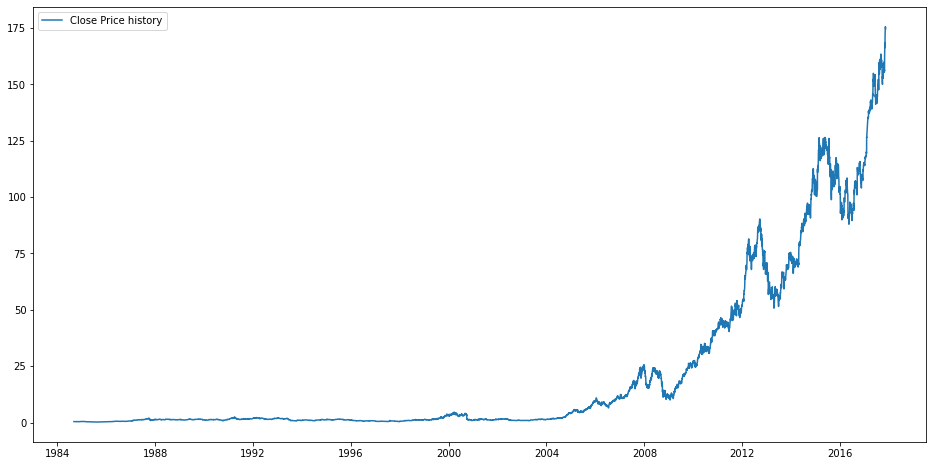

In [13]:
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df['Date']
plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label='Close Price history')
plt.legend(loc="best")

## 4. Sort the dataset on date time and filter “Date” and “Close” columns:

In [4]:

from datetime import datetime

def datetime_to_float(d):
    epoch = datetime.utcfromtimestamp(0)
    total_seconds = (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    new_dataset["Date"][i] = datetime_to_float(data['Date'][i])
    new_dataset["Close"][i] = data["Close"][i]

In [5]:
new_dataset.head()

,Date,Close
0,1381190400.0,155.8
1,1381276800.0,155.55
2,1381363200.0,160.15
3,1381449600.0,160.05
4,1381708800.0,159.45


## 5. Normalize the new filtered dataset:

In [6]:
final_dataset = new_dataset.values

amount_of_train_data = 987
train_data = final_dataset[0:987, :]
valid_data = final_dataset[987:, :]

new_dataset.index = new_dataset.Date
# new_dataset.drop("Date", axis=1, inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_dataset[["Close", "Date"]])

x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i - 60:i, 0])
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

## 6. Build and train the LSTM model:

In [7]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

927/927 - 18s - loss: 9.3373e-04 - 18s/epoch - 19ms/step


## 7. Take a sample of a dataset to make stock price predictions using the LSTM model:

In [8]:
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values.reshape(-1, 2)
# inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.fit_transform(inputs_data)
inputs_data

array([[0.00000000e+00, 2.38233976e-01],
       [5.47645126e-04, 2.37113402e-01],
       [1.09529025e-03, 2.57731959e-01],
       ...,
       [9.97809419e-01, 5.17929180e-01],
       [9.98357065e-01, 4.77588525e-01],
       [1.00000000e+00, 5.04258180e-01]])

In [9]:
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i - 60:i, 0])
X_test = np.array(X_test).astype('float32')

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_closing_price = lstm_model.predict(X_test)

37/37 [==============================] - 1s 15ms/step


In [10]:
predicted_date = inputs_data.T[1][60:].reshape(-1, 1)
predicted_date

array([[0.24069924],
       [0.24271627],
       [0.24137158],
       ...,
       [0.51792918],
       [0.47758853],
       [0.50425818]])

In [11]:
predicted_closing_price = scaler.inverse_transform(np.concatenate((predicted_date, predicted_closing_price), axis=1))

## 8. Save the LSTM model:

In [12]:
lstm_model.save("models/lstm_model.h5")

## 9. Visualize the predicted stock costs with actual stock costs:

In [13]:
new_dataset.drop("Date", axis=1, inplace=True)

C:\Users\tarza\AppData\Local\Temp\ipykernel_23732\474774232.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data["Predictions"] = np.array([*np.zeros(60), *predicted_closing_price[:, 1]])


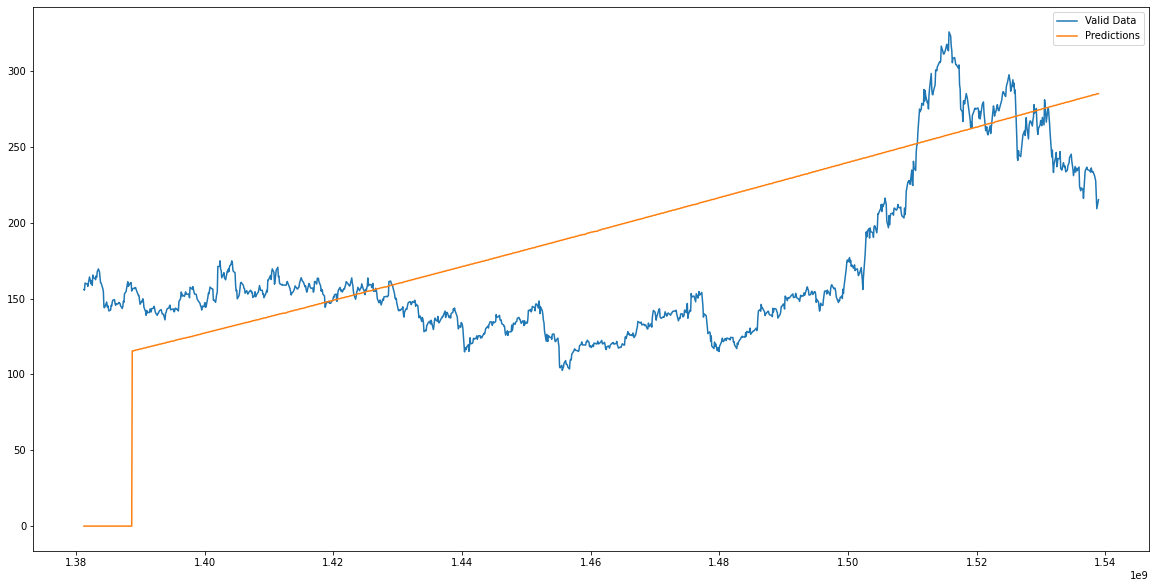

In [14]:
# train_data = new_dataset.values[:amount_of_train_data]
# train_data = pd.DataFrame(train_data, columns=['Close'])
# plt.plot(train_data["Close"], label='Train Data')

valid_data = new_dataset[amount_of_train_data:]
valid_data["Predictions"] = np.array([*np.zeros(60), *predicted_closing_price[:, 1]])
plt.plot(valid_data[["Close", "Predictions"]], label=['Valid Data', 'Predictions'])

plt.legend(loc="best")